In [ ]:
using Plots

using Ipopt
using JuMP

In [7]:


# Coefficients du modèle
const A = 10.0
const B = 1.0
const C = 3.0
const T = 20

# Valeurs initiales
const s0 = 0.2
const i0 = 0.8
const m0 = 0.0

# Valeurs initiales 
#const p_s_0 = -6.3486
#const p_i_0 = -7.654e+1
#const p_m_0 = -6.2821e-2

# Autres paramètres
const N = 10000
const ε = 1e-9
const dt = 1/N

# Valeurs des paramètres SIMR
const b = 0.01
const c = 1.1
const a1 = 0.08
const a2 = 0.005
const g1 = 0.02
const g2 = 0.5
const η = 0.8

# Valeurs maximales des contrôles
const umax = 0.8
const vmax = 0.8
const u_sing = 0.188

# Switching points
const t1_u = 4.45
const t2_u = 13.55
const t1_v = 6.49


# Définir le modèle d'optimisation
model = Model(Ipopt.Optimizer)

# Variables d'état s(t), i(t), et m(t)
@variable(model, s[t=0:N] >= 0)
@variable(model, i[t=0:N] >= 0)
@variable(model, m[t=0:N] >= 0)

# Contraintes initiales
@constraint(model, s[0] == s0)
@constraint(model, i[0] == i0)
@constraint(model, m[0] == m0)

# Contrainte finale sur i(T)
@constraint(model, i[T] <= 5e-4)

# Définition de u_* et v_*
function u(t)

    if 0 <= t <= t1_u
        return umax
    elseif t1_u <= t <= t2_u
        return u_sing
    elseif t2_u <= t <= T
        return 0
    end
end

function v(t)
    if 0 <= t <= t1_v
        return vmax
    elseif t1_v <= t <= T
        return 0
    end
end

# Expression pour J1(u, v)
@expression(model, J1, sum((A*i[t] + B*u(t) + C*v(t)) for t in 0:T))

# Équations différentielles
for t in 0:T-1
    @constraint(model, s[t+1] == s[t] + dt * (b - b*s[t] - c*s[t]*i[t] + (a1*i[t] + a2*m[t])*s[t] - η*u(t)*s[t]))
    @constraint(model, i[t+1] == i[t] + dt * (c*s[t]*i[t] - b*i[t] - (g1 + a1)*i[t] + (a1*i[t] + a2*m[t])*i[t] - i[t]*v(t)))
    @constraint(model, m[t+1] == m[t] + dt * (-(a2 + g2 + b)*m[t] + (a1*i[t] + a2*m[t])*m[t] + i[t]*v(t)))
end

# Objectif de minimisation
@objective(model, Min, J1)

In [ ]:
# Résoudre le problème d'optimisation
optimize!(model)

# Afficher les résultats
println("Valeur optimale de J1(u, v) : ", objective_value(model))
println("Valeurs optimales de s(T) : ", [value(s[T])] )
println("Valeurs optimales de i(T) : ", [value(i[T])] )
println("Valeurs optimales de m(T) : ", [value(m[T])] )

t_values = 0:0.1:T  # Plage de valeurs de t
u_values = [u(t) for t in t_values]
plot(t_values, u_values, xlabel="t", ylabel="u(t)", label="u(t)", legend=true)

v_values = [v(t) for t in t_values]
plot(t_values, v_values, xlabel="t", ylabel="v(t)", label="v(t)", legend=true)

# This is the new portion of the code that has been inspired by the origin code given


In [18]:


using Plots, Ipopt, JuMP, QuadGK


#JuMP model, Ipopt solver

sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)



# Parameters

# Coefficients du modèlprintln("Valeurs optimales de s(T) : ", [value(s[T])] )
# println("Valeurs optimales de i(T) : ", [value(i[T])] )
# println("Valeurs optimales de m(T) : ", [value(m[T])] )
const A = 10.0
const B = 1.0
const C = 3.0
const T = 20

# Valeurs initiales
const s0 = 0.2
const i0 = 0.8
const m0 = 0.0

# Autres paramètres
const N = 20
const ε = 1e-9
#const dt = 1/N

# Valeurs des paramètres SIMR
const b = 0.01
const c = 1.1
const a1 = 0.08
const a2 = 0.005
const g1 = 0.02
const g2 = 0.5
const η = 0.8

# Valeurs maximales des contrôles
const umax = 0.8
const vmax = 0.8


# Variables d'état s(t), i(t), et m(t) et de control u(t) et v(t)

@variables(sys, begin
    0.0 <= Δt                      # time step (unknown as tf is free)
    0 <= s[1:N+1]                  # s state (voire s[t=0:N] >= 0 je ne sais pas ce que ça change)
    0 <= i[1:N+1]                  # i state (i[t=0:N] >= 0)
    0 <= m[1:N+1]                  # m state (m[t=0:N] >= 0)
    0 <= u[t=1:N+1] <= umax         # u control
    0 <= v[t=1:N+1] <= vmax         # v control
end)




# Expression pour J1(u, v)
#@NLexpression(sys, J1, quadgk(t -> A*i[t] + B*u[t] + C*v[t], 0, T)[1])
@expression(sys, J1,sum((A*i[t] + B*u[t] + C*v[t]) for t in 1:T))
# Objective
@objective(sys, Max, J1)


# Boundary constraints 

@constraints(sys, begin
    con_s0, s[1] == s0
    con_i0, i[1] == i0
    con_m0, m[1] == m0
    con_iT, i[T] <= 5e-4
end)


# Dynamics
@NLexpressions(sys, begin
    # s' = b - b.s - c.s.i + (a1.i + a2.m).s - η.u.s
    ds[j = 1 : N + 1], ( b - b * s[j] - c * s[j] * i[j] + ( a1 * i[j] + a2 * m[j] ) * s[j] - η * u[j] * s[j] )
    # i' = c.s.i - b.i - (g1 + a1).i + (a1.i + a2.m).i - i.v
    di[j = 1 : N + 1], ( c * s[j] * i[j] - b * i[j] - ( g1 + a1 ) * i[j] + ( a1 * i[j] + a2 *m[j] ) * i[j] - i[j] * v[j])
    # m' = -(a2 + g2 + b).m + (a1.i + a2.m).m + i.v
    dm[j = 1 : N + 1], ( - ( a2 + g2 + b ) * m[j] + ( a1 * i[j] + a2 * m[j] ) * m[j] + i[j] * v[j] )
end)

# Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_ds[j = 1:N ], s[j+1] == s[j] + Δt * (ds[j] + ds[j+1])/2.0
    con_di[j = 1:N ], i[j+1] == i[j] + Δt * (di[j] + di[j+1])/2.0
    con_dm[j = 1:N ], m[j+1] == m[j] + Δt * (dm[j] + dm[j+1])/2.0
end)

In [19]:
# Solves for the control and state
println("Solving...")
status = optimize!(sys)

if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")

elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
ss = value.(s)
ii = value.(i)
mm = value.(m)
uu = value.(u)
vv = value.(v)
Δtt = value.(Δt)
p_s = -[ dual(con_ds[j]) for j = 1:N - 1]
p_i = -[ dual(con_di[j]) for j = 1:N - 1]
p_m = -[ dual(con_dm[j]) for j = 1:N - 1];

Solving...


This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      503
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     2360

Total number of variables............................:      106
                     variables with only lower bounds:       64
                variables with lower and upper bounds:       42
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

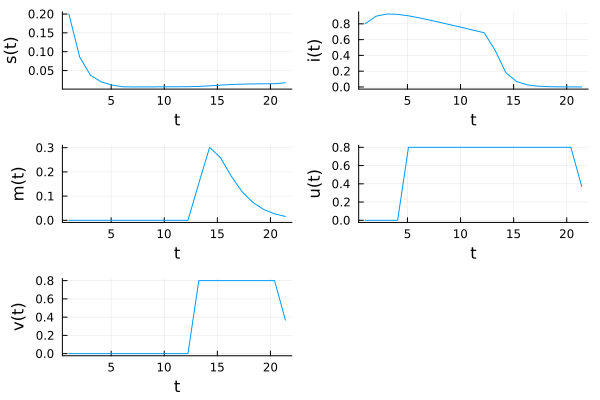

In [21]:
# Plots: state and control
t = (1:N+1)*Δtt
s_plot = plot(t, ss, xlabel = "t", ylabel = "s(t)", legend = false, fmt = :png)
i_plot = plot(t, ii, xlabel = "t", ylabel = "i(t)", legend = false, fmt = :png)
m_plot = plot(t, mm, xlabel = "t", ylabel = "m(t)", legend = false, fmt = :png)
u_plot = plot(t, uu, xlabel = "t", ylabel = "u(t)", legend = false, fmt = :png)
v_plot = plot(t, vv, xlabel = "t", ylabel = "v(t)", legend = false, fmt = :png)

display(plot(s_plot, i_plot, m_plot, u_plot, v_plot, layout = (3,2)))

In [23]:
# Plots: adjoint state
tt = (t[1:end-1] + t[2:end])/2.0
p_s_plot = plot(tt, p_s, xlabel = "t", ylabel = "ps(t)", legend = false, fmt = :png)
p_i_plot = plot(tt, p_i, xlabel = "t", ylabel = "pi(t)", legend = false, fmt = :png)
p_m_plot = plot(tt, p_m, xlabel = "t", ylabel = "pm(t)", legend = false, fmt = :png)
display(plot(p_s_plot, p_i_plot, p_m_plot, layout = (2,2)))

BoundsError: BoundsError: attempt to access 21-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [2:22]

In [24]:
# Afficher les résultats
println("Valeur optimale de J1(u, v) : ", objective_value(sys))
println("Valeur optimale de s(T) : ", [value(s[T])] )
println("Valeur optimale de i(T) : ", [value(i[T])] )
println("Valeur optimale de m(T) : ", [value(m[T])] )
println("Valeur optimale de ps(0) : ", [value(p_s[0])] )
println("Valeur optimale de pi(0) : ", [value(p_i[0])] )
println("Valeur optimale de pm(0) : ", [value(p_m[0])] )
println("Valeur optimale de ps(T) : ", [value(p_s[T])] )
println("Valeur optimale de pi(T) : ", [value(p_i[T])] )
println("Valeur optimale de pm(T) : ", [value(p_m[T])] )


Valeur optimale de J1(u, v) : 138.71987344390234
Valeur optimale de s(T) : [0.015172802172208538]
Valeur optimale de i(T) : [0.0005000099995989246]
Valeur optimale de m(T) : [0.02653703267213108]


BoundsError: BoundsError: attempt to access 19-element Vector{Float64} at index [0]